In [32]:
%%capture
%run "5 - Statistics.ipynb"
%run "6 - Probability.ipynb"

# Exploring Your Data
Before you start building models and looking for answers, you should explore the data.

## Exploring One-Dimensional Data
One-dimensional data is just a collection of some type, e.g., numbers.

A good place to start is with summary statistics.

In [18]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=''):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), histogram.values(), width=bucket_size, edgecolor='white')
    plt.title(title)
    plt.show()

In [19]:
import random

random.seed(0)

# uniform #'s will be between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal #'s will be from the normal distribution with mean of 0 and standard deviation of 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

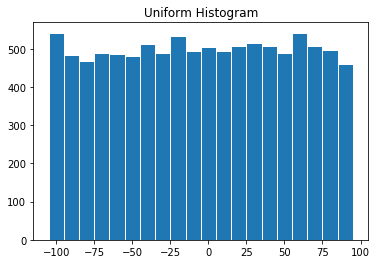

In [20]:
plot_histogram(uniform, 10, 'Uniform Histogram')

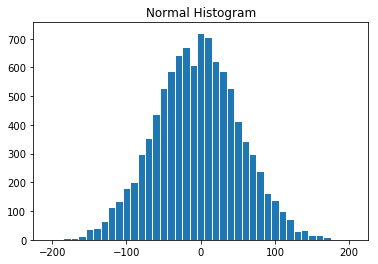

In [22]:
plot_histogram(normal, 10, 'Normal Histogram')

## Two Dimensions

In [35]:
def random_normal():
    """retuns random #'s from standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

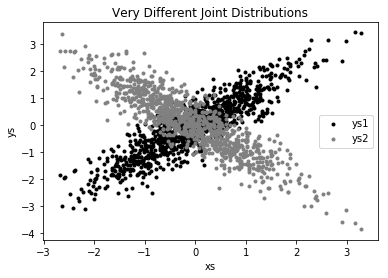

In [36]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1');
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2');
plt.xlabel('xs');
plt.ylabel('ys');
plt.legend(loc=5);
plt.title('Very Different Joint Distributions');

In [37]:
correlation(xs, ys1), correlation(xs, ys2)

(0.8906979918310958, -0.8914517682110948)